# ADMM Example

## Setup

In [137]:
using Suppressor
using BM3D
using Images: assess_psnr
using MIRT: jim
using PyCall
using Plots: plot
np = pyimport("numpy")
cv = pyimport_conda("cv2", "opencv")
# Inclucde needed files
include("admm.jl")
include("load_fastmri_data.jl")
include("system_ops.jl")
include("create_sampling_mask.jl")
include("utils.jl")
include("primal.jl")
@suppress include("dncnn.jl") # Suppress weight printing

# Create a single Julia function for calling nlmeans
function nlMeans(img::Array{Float64, 2}, h::Number = 3) 
    pyimg = np.uint8(convert(Array{UInt8,2}, round.(img*255))) # Convert julia image to np.uint8 array
    img_denoised = float32.(cv.fastNlMeansDenoising(pyimg, h=h)) ./ 255
end

# Useful to flip images
function rev(img::AbstractArray{T, 2}) where T
    img[end:-1:1, end:-1:1]
end;

In [2]:
# using Pkg; Pkg.add("LinearMapsAA")

# Create an undersampled data set

In [156]:
# Load a fully sampled image
fName = "file1000000.h5" # File name
fName = joinpath(dirname(pwd()), "data", fName) # Full file name
img = abs.(load_fastmri_data(fName))
img = img / max(img...)
(M,N) = size(img);

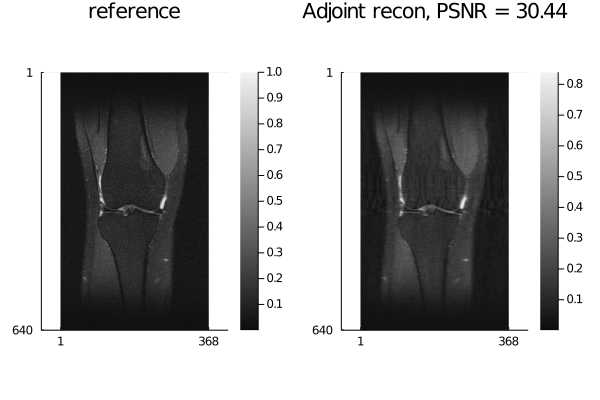

In [138]:
# Specify acceleration factor for sampling mask
R = 4
M_us = Int(round(M/R)) # Undersampled number of points
# Create a 1D random undersampling mask
sampleMask = create_sampling_mask(M, N, R, seed=0)
# Create linear map, A, that describes the MRI system model
A = LinearMapAA(x -> sys_forw(x, sampleMask), x -> sys_adj(x,sampleMask), (M_us*N, M*N))
# Apply model to image -> generate an undersampled k-space
y = A*img[:]
# Applying adjoint model to k-space reconstructs the image (poorly)
x0 = abs.(reshape(A'*y,M,N))
# Make some plots
psnrAdjoint = assess_psnr(x0, img) # PSNR
j1 = jim(abs.(rev(img)),title="reference")
j2 = jim(rev(x0),title="Adjoint recon, PSNR = $(round(psnrAdjoint, digits = 2))")
plot(j1, j2)

## Plug and Play!

In [64]:
nIter = 10

10

### Using DNCNN

In [88]:
x̂DNN = admm((z,η,μ) -> primal(z,η,μ,A,sampleMask,y),
    (x) -> dncnn_denoise(float32.(abs.(x))),
    1,
    x0, 
    niter = nIter)
x̂DNN = reshape(x̂DNN,M,N);

1

2

3

4

5

6

7

8

9

10

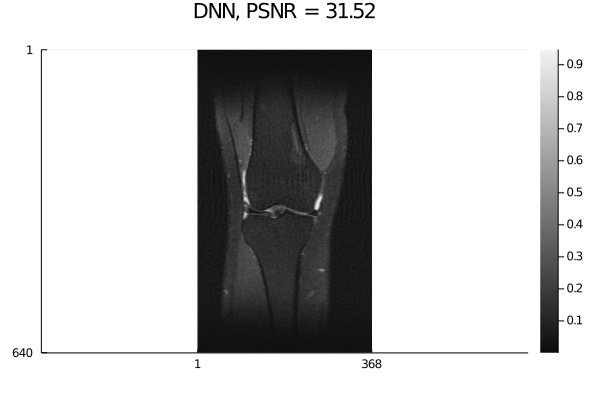

In [95]:
psnrDNN = assess_psnr(x̂DNN, img) # PSNR
pDNN = jim(abs.(rev(x̂DNN)), title="DNN, PSNR = $(round(psnrDNN, digits = 2))")

### Using NLMeans

In [152]:
h = 0.1
plug = (x) -> nlMeans(abs.(x), h)
x̂NLMeans = admm((z,η,μ) -> primal(z,η,μ,A,sampleMask,y),
    plug,
    1,
    x0, 
    niter = nIter)
x̂NLMeans = reshape(x̂NLMeans,M,N);

1

2

3

4

5

6

7

8

9

10

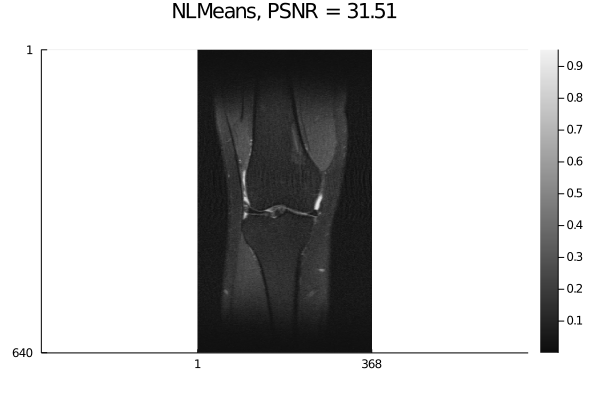

In [153]:
psnrNLMeans = assess_psnr(x̂NLMeans, img) # PSNR
pNLMeans = jim(abs.(rev(x̂NLMeans)), title="NLMeans, PSNR = $(round(psnrNLMeans, digits = 2))")

### Using BM3D

In [142]:
h    = 0.01
plug = (x) -> @suppress bm3d(abs.(x), h)
x̂BM3D = admm((z,η,μ) -> primal(z,η,μ,A,sampleMask,y),
    plug,
    1,
    x0, 
    niter = nIter)
x̂BM3D = reshape(x̂BM3D,M,N);

1

2

3

4

5

6

7

8

9

10

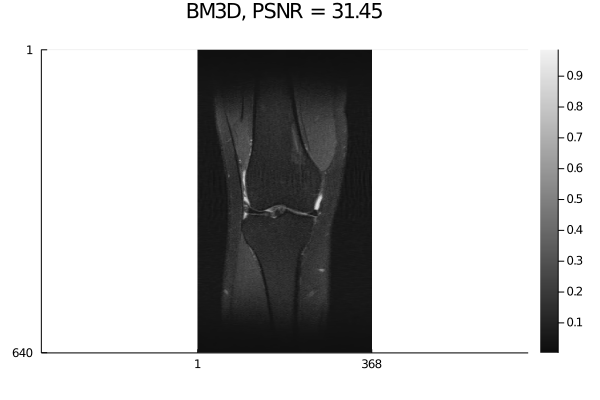

In [154]:
psnrBM3D = assess_psnr(x̂BM3D, img) # PSNR
pBM3D = jim(abs.(rev(x̂BM3D)), title="BM3D, PSNR = $(round(psnrBM3D, digits = 2))")

In [155]:
@show psnrNLMeans
@show psnrDNN # PSNR
@show psnrBM3D

psnrNLMeans = 31.50810475348052
psnrDNN = 31.51542595573092
psnrBM3D = 31.452268500075483


31.452268500075483